# Demonstration of the processing steps for converting the raw data

* RADAR type is FMCW
* 60000 chirps per file = to 60 seconds record time
* 1ms for one chirp
* Bandwith: 400MHz


Processing code ported from a matlab version created by Aleksander Angelov who modified the original Test SDR-KIT for  extracting micro-Doppler signature by WWW.ANCORTEK.COM (Micro-Doppler Signature of Human Movement)

In [2]:
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()
if cwd == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif cwd == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif cwd == "/export/home/2192793m/Level-4-Project/":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
INTERIM_PATH = BASE_PATH + 'data/interim/'
RESULTS_PATH = BASE_PATH + "results/data_processing_demonstration/"
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import colors
from scipy.signal import butter, freqz, lfilter, spectrogram

In [5]:
SAVE_GRAPHS = False # change to true to overwrite

In [6]:
# Load in file to pandas dataframe
# Dataset 97 is sitting and standing (0 degrees aspect angle)
df = pd.read_csv(INTERIM_PATH + "Dataset_97.dat", header=None)[1]

In [7]:
# Grab RADAR settings from top of file
center_frequency = float(df.iloc[1])# 5800000000Hz (5.6 GHz)
sweep_time = float(df.iloc[2])/1000  # convert to seconds (0.001 seconds)
number_of_time_samples = float(df.iloc[3])# 128
bandwidth = float(df.iloc[4]) # 400000000Hz (400 MHz)
sampling_frequency = number_of_time_samples/sweep_time
'''
record length = 60s
              = 60000 chirps with sweep time of 1ms
              = (7680000 measurments / 128 time samples) with sweep time of 1ms
'''
record_length = (len(df.iloc[5:])/number_of_time_samples) * sweep_time
number_of_chirps = record_length/sweep_time # 60000

In [8]:
# Put data values into an np array and convert to complex (originally str)
data = df.iloc[5:].apply(complex).values

In [9]:
# Reshape into chirps over time
data_time = np.reshape(data, (int(number_of_chirps),int(number_of_time_samples)))
data_time = np.rot90(data_time)

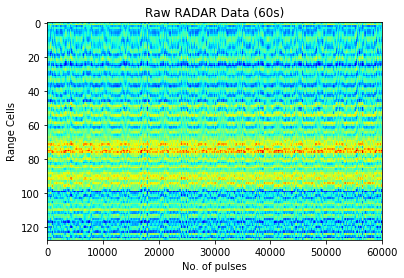

In [10]:
# flip upside down to get range cell axis to be correct
plt.imshow(np.flipud(abs(data_time)),cmap='jet', aspect="auto")
plt.title("Raw RADAR Data (60s)")
plt.xlabel("No. of pulses")
plt.ylabel("Range Cells")
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "raw_reshaped_60s.pdf", format='pdf')
plt.show()

In [11]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))
win = np.ones(data_time.shape)

In [12]:
# Apply fast fourier transform which should compute distance (range) from objects
fft_applied = np.fft.fftshift(np.fft.fft((data_time * win),axis=0), 0)

In [13]:
# take half as the other half looks to contain only noise
data_range = fft_applied[1:int(number_of_time_samples/2), :] 

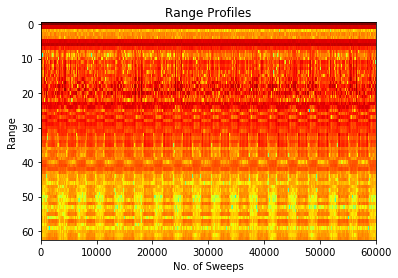

In [14]:
plt.imshow(20*np.log10(np.flipud(abs(data_range))),cmap='jet', aspect="auto")
plt.title("Range Profiles")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range")
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "range_profiles.pdf", format='pdf')
plt.show()

 Moving Target Indicator (MTI) Filter :
*  suppress echoes from clutter
 * clutter is stationary or close to stationary
*  The MTI filter is a high pass filter that filters out the low Doppler frequencies,

(information taken from http://www.diva-portal.se/smash/get/diva2:1143293/FULLTEXT01.pdf section 5.1)

In [15]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    return int(np.floor(x))

In [16]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1 # I am unclear why an odd number is necessary (further research needed)
ns = x

In [17]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

In [18]:
(b, a) = butter(4, 0.01, btype="high")

In [19]:
# Apply Filter
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)

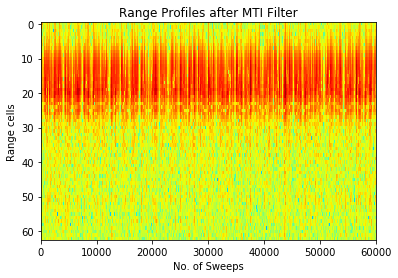

In [20]:
plt.imshow(20*(np.log10(np.flipud(abs(data_range_MTI)))),cmap='jet', aspect="auto")
plt.title("Range Profiles after MTI Filter")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range cells")
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "range_profiles_after_MTI_filter.pdf", format='pdf')
plt.show()

Spectrogram processing for 2nd FFT to get Doppler

In [21]:
# Selects range bins
bin_indl = 5
bin_indu = 25

time_window_length = 200
overlap_factor = 0.95
overlap_length = np.round(time_window_length * overlap_factor)
pad_factor = 4
fft_points = pad_factor * time_window_length

prf = 1/sweep_time
doppler_bin = prf / fft_points
doppler_axis = np.arange(-prf / 2, prf / 2 - doppler_bin + 1, doppler_bin)
whole_duration = data_range_MTI.shape[1] / prf
num_segments = np.floor((data_range_MTI.shape[1] - time_window_length) /
    (np.floor(time_window_length * (1 - overlap_factor))))

In [22]:
data_spec_MTI=0
for rbin in range(bin_indl-1, bin_indu):
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(time_window_length),
                            noverlap=overlap_length,
                            NFFT=time_window_length, 
                            mode='complex',
                            pad_to=fft_points )

    data_spec_MTI=data_spec_MTI+abs(s);                                


In [23]:
time_axis = np.linspace(0, whole_duration, data_spec_MTI.shape[1])

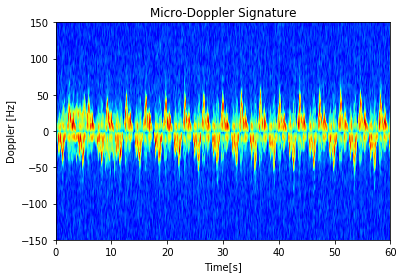

In [24]:
plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "micro-doppler_signature.pdf", format='pdf')
plt.show()

### Comparing Clipping Value

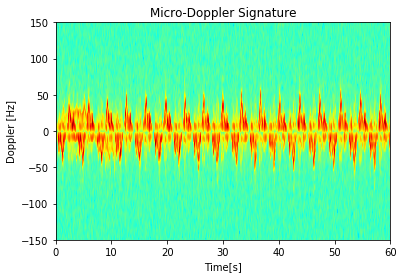

In [43]:
minimum_value = 0
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

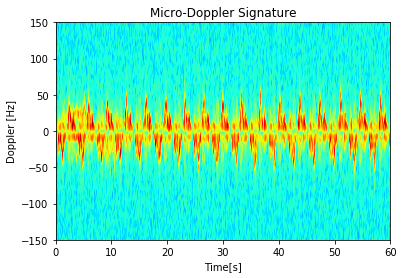

In [44]:
minimum_value = 5
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

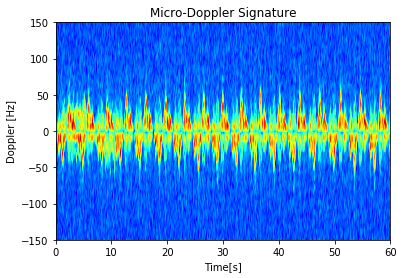

In [45]:
minimum_value = 15
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

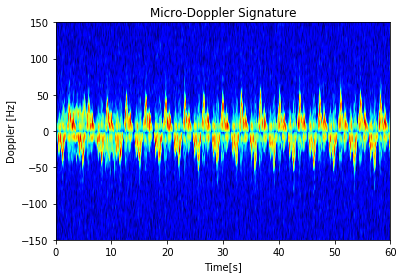

In [46]:
minimum_value = 20
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

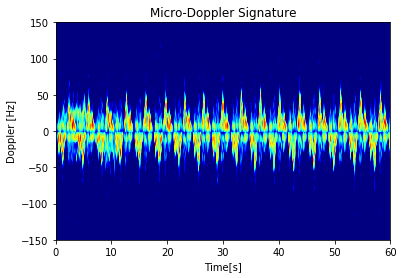

In [47]:
minimum_value = 25
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

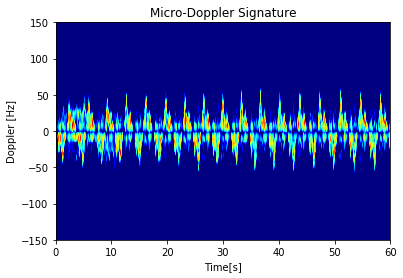

In [49]:
minimum_value = 30
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

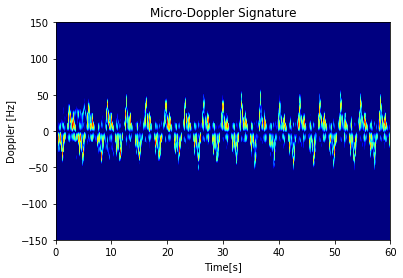

In [48]:
minimum_value = 35
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))),cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.show()

In [33]:
image_width = 150
image_height = 150
minimum_value = 35
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)

In [ ]:
save_spectrograms = True
folder = "C:/Users/macka/Desktop/test/"

In [ ]:
# Taking 3 second slices
window_size = 300  # 3 seconds
iterations = data_spec_MTI.shape[1] - window_size
step_size = 10  # 0.1 seconds
for i in range(5500, iterations, step_size):
    start_time = time.time()
    center = int(data_spec_MTI.shape[0]/2)
    data_spec_small = data_spec_MTI[(center-150):(center+150), i:(i + window_size)]
    if save_spectrograms:
        # used for saving 150px x 150px image of the spectrogram
        w = image_width
        h = image_height
        fig = plt.figure(frameon=False)
        fig.set_size_inches(w,h)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(20 * np.log10(abs(data_spec_small)), cmap='jet', norm=norm, aspect="auto")
        fig.savefig(folder + str(i) + ".png", dpi=1)
        break
    break
    time_for_row = (time.time() - start_time)/60
    print("\n--- %s minutes ---" % (time_for_row))
        